In [1]:
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import os
import time
import sys
sys.path.append(os.getcwd())
from hawkes import dataLoader, inference, simulate, thinning_optimize #not importing fit because some error with tick installation
import matplotlib.pyplot as plt
np.random.seed(2)
np.set_printoptions(precision=17)
%matplotlib inline

# Generate Fake Data

## Create Fake Params

[[ 5.9999999999999998e-01  2.8341993164460882e-01 -1.3387809608905787e-01
  -6.3239534737118602e-02  2.9872241020718365e-02  1.4110647513605464e-02
  -6.6653979229453833e-03  3.1485110395088308e-03 -1.4872513059998151e-03
   7.0252777247470464e-04 -3.3185062208870018e-04  1.5675513438100051e-04]
 [-2.8341993164460882e-01  5.9999999999999998e-01 -2.8341993164460882e-01
  -1.3387809608905787e-01 -6.3239534737118602e-02 -2.9872241020718365e-02
  -1.4110647513605464e-02 -6.6653979229453833e-03  3.1485110395088308e-03
   1.4872513059998151e-03  7.0252777247470464e-04  3.3185062208870018e-04]
 [-1.3387809608905787e-01 -2.8341993164460882e-01  5.9999999999999998e-01
  -2.8341993164460882e-01  1.3387809608905787e-01  6.3239534737118602e-02
   2.9872241020718365e-02 -1.4110647513605464e-02 -6.6653979229453833e-03
  -3.1485110395088308e-03  1.4872513059998151e-03  7.0252777247470464e-04]
 [-6.3239534737118602e-02  1.3387809608905787e-01  2.8341993164460882e-01
   5.9999999999999998e-01 -2.834199

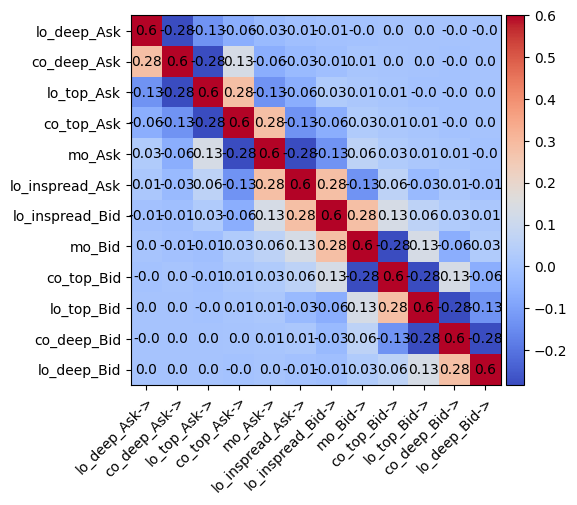

In [2]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .6
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

print(mat)
        
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
# plt.show()


In [3]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

(0.8878588873324558+0j)

In [4]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0
with open("fakeData_Params_sod_eod_dictTOD_constt", "wb") as f:
    pickle.dump(faketod, f)
    
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])


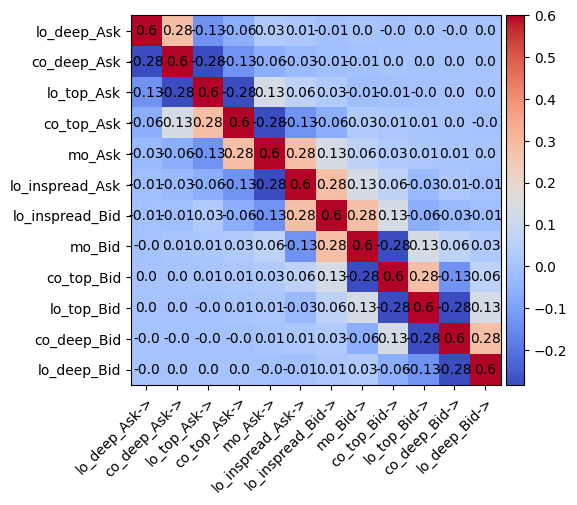

In [5]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()




In [6]:
with open("fake_ParamsInferredWCutoff_sod_eod_true_optimize", "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [7]:
#os.mkdir("./simulated_data")
faketod, fakeparams=thinning_optimize.preprocessdata(paramsPath="fake_ParamsInferredWCutoff_sod_eod_true_optimize", todPath="fakeData_Params_sod_eod_dictTOD_constt")
#print(fakeparams)

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
# orig_stdout=sys.stdout
# f = open('logging_optimized.txt', 'w')
# sys.stdout = f
thinningtime=0
np.random.seed(1)
start=time.perf_counter_ns()
for i in range(1):
    T, lob, lobL3, timefraction=thinning_optimize.simulate2(400, fakeparams, faketod, beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    thinningtime+=timefraction
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)
    print("LOB ", i, ": ", lob)
end=time.perf_counter_ns()
# sys.stdout=orig_stdout
# f.close()
print("Simulation, took ", str((end-start)/10**9), "seconds.")
print("ThinningOgataIS_optimized took ", str(thinningtime/(10**9)), "seconds. ")
print("TimeFraction is: ", str(round(thinningtime*100/(end-start), 2)), "%. ")
#101.59251688753126

In [ ]:
# orig_stdout=sys.stdout
# f = open('logging.txt', 'w')
# sys.stdout = f
thinningtime=0
np.random.seed(1)
start=time.perf_counter_ns()
for i in range(1):
    T, lob, lobL3, timefraction=simulate.simulate(400, "fake_ParamsInferredWCutoff_sod_eod_true","fakeData_Params_sod_eod_dictTOD_constt" , beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    thinningtime+=timefraction
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)
    print("LOB ", i, ": ", lob)
end=time.perf_counter_ns()
# sys.stdout=orig_stdout
# f.close()
print("Simulation, took ", str((end-start)/10**9), "seconds.")
print("ThinningOgataIS took ", str(thinningtime/(10**9)), "seconds. ")
print("TimeFraction is: ", str(round(thinningtime*100/(end-start), 2)), "%. ")

## Benchmarking

In [8]:

t_max=20
Times=[j*100 for j in range(1, t_max+1)]
trials=5
res= np.zeros(shape=(trials+1, t_max, 3)) # res[trials][Timeperiod][optimized/nonoptimized][simulation, thinning, timefraction]
res2= np.zeros(shape=(trials+1, t_max, 3))
for i in range(1, trials+1):
    for Timeperiod in Times:
        np.random.seed(1)
        start=time.perf_counter_ns()
        T, lob, lobL3, timefraction=thinning_optimize.simulate2(Timeperiod, fakeparams, faketod, beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
        end=time.perf_counter_ns()
        res[i][Timeperiod//100 - 1][0]=abs(end-start)/10**9 + res[i-1][Timeperiod//100 - 1][0]
        res[i][Timeperiod//100 - 1][1]=abs(timefraction)/10**9 + res[i-1][Timeperiod//100 - 1][1]
        res[i][Timeperiod//100 - 1][2]=round(res[i][Timeperiod//100 - 1][1]/res[i][Timeperiod//100 - 1][0], 2) 
        np.random.seed(1)
        start=time.perf_counter_ns()
        T, lob, lobL3, timefraction=simulate.simulate(Timeperiod, "fake_ParamsInferredWCutoff_sod_eod_true","fakeData_Params_sod_eod_dictTOD_constt" , beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
        end=time.perf_counter_ns()
        res2[i][Timeperiod//100 - 1][0]=abs(end-start)/10**9 + res2[i-1][Timeperiod//100 - 1][0]
        res2[i][Timeperiod//100 - 1][1]=abs(timefraction)/10**9 + res2[i-1][Timeperiod//100 - 1][1]
        res2[i][Timeperiod//100 - 1][2]=round(res2[i][Timeperiod//100 - 1][1]/res2[i][Timeperiod//100 - 1][0], 2) 
        
        print("Done: (", i, ", ", Timeperiod, ")")

print("res: ", res)
print("res2: ", res2)


Done: ( 1 ,  100 )
Done: ( 1 ,  200 )
Done: ( 1 ,  300 )
Done: ( 1 ,  400 )
Done: ( 1 ,  500 )
triggered
triggered
Done: ( 1 ,  600 )
triggered
triggered
Done: ( 1 ,  700 )
triggered
triggered
Done: ( 1 ,  800 )
triggered
triggered
Done: ( 1 ,  900 )
triggered
triggered
Done: ( 1 ,  1000 )
triggered
triggered
Done: ( 1 ,  1100 )
triggered
triggered
Done: ( 1 ,  1200 )
triggered
triggered
Done: ( 1 ,  1300 )
triggered
triggered
Done: ( 1 ,  1400 )
triggered
triggered
Done: ( 1 ,  1500 )
triggered
triggered
Done: ( 1 ,  1600 )
triggered
triggered
Done: ( 1 ,  1700 )
triggered
triggered
Done: ( 1 ,  1800 )
triggered
triggered
triggered
triggered
Done: ( 1 ,  1900 )
triggered
triggered
triggered
triggered
Done: ( 1 ,  2000 )
Done: ( 2 ,  100 )
Done: ( 2 ,  200 )
Done: ( 2 ,  300 )
Done: ( 2 ,  400 )
Done: ( 2 ,  500 )
triggered
triggered
Done: ( 2 ,  600 )
triggered
triggered
Done: ( 2 ,  700 )
triggered
triggered
Done: ( 2 ,  800 )
triggered
triggered
Done: ( 2 ,  900 )
triggered
triggere

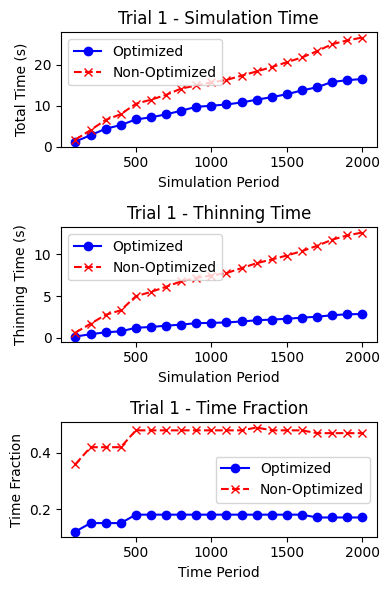

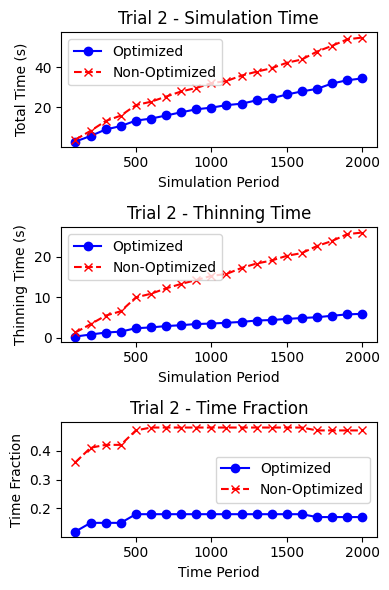

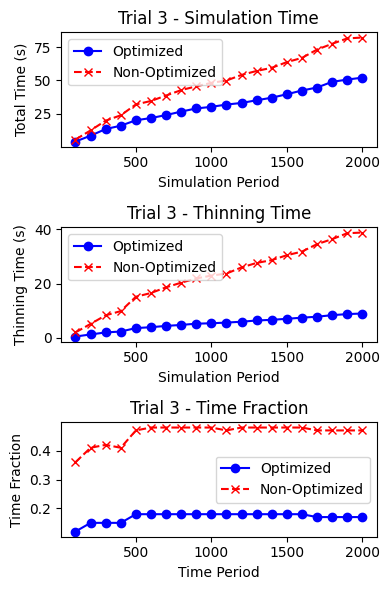

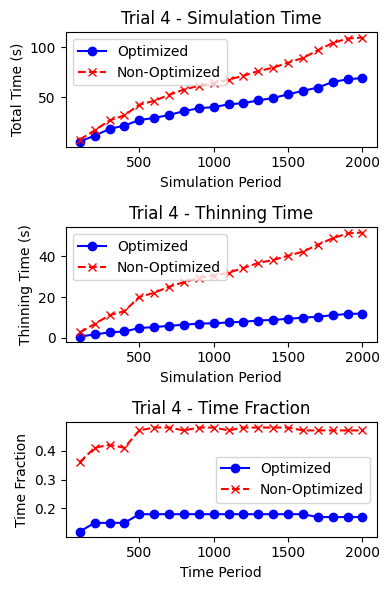

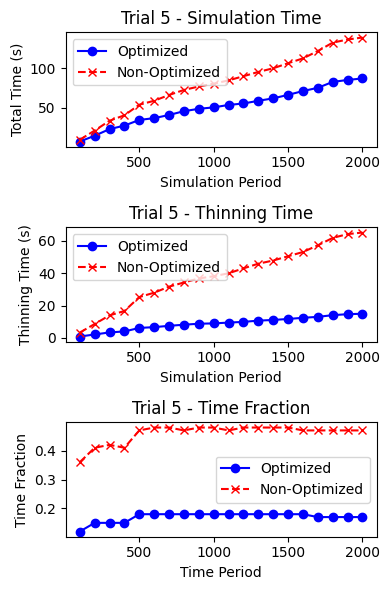

In [26]:
time_periods=np.arange(100, 2100, 100)
for trial in range(1, trials + 1):
    plt.figure(figsize=(4, 6))
    
    # Plot simulation time
    plt.subplot(3, 1, 1)
    plt.plot(time_periods, res[trial, :, 0], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 0], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'Trial {trial} - Simulation Time')
    plt.xlabel('Simulation Period')
    plt.ylabel('Total Time (s)')
    plt.legend()

    # Plot thinning time
    plt.subplot(3, 1, 2)
    plt.plot(time_periods, res[trial, :, 1], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 1], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'Trial {trial} - Thinning Time')
    plt.xlabel('Simulation Period')
    plt.ylabel('Thinning Time (s)')
    plt.legend()

    # Plot time fraction
    plt.subplot(3, 1, 3)
    plt.plot(time_periods, res[trial, :, 2], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 2], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'Trial {trial} - Time Fraction')
    plt.xlabel('Time Period')
    plt.ylabel('Time Fraction')
    plt.legend()

    # Adjust layout and show the plot for the current trial
    plt.tight_layout()
    plt.show()